First, install missing libraries and import them

In [ ]:
%pip install scikit-image
%pip install numpy
%pip install matplotlib 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:

import skimage as ski 
import numpy as np
import matplotlib.pyplot as plt 

Let's try to import and show the "camera" figure we saw during theory...

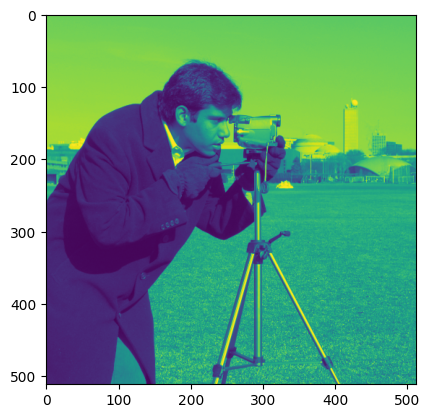

In [2]:
camera = ski.data.camera()
plt.imshow(camera)

... But wait... What happened to the colours? 
The image is in black and white (single value), but plt.imshow applies a colourmap that transforms each single value into a colour in a scale. Let's fix it with a map ranging from white to black

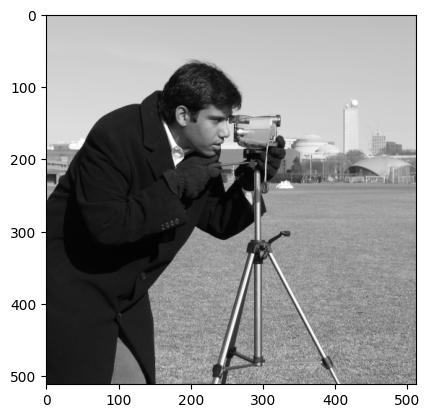

In [3]:
plt.imshow(camera, cmap='gray')

Now, let's try to threshold this image as we saw during the presentation... 

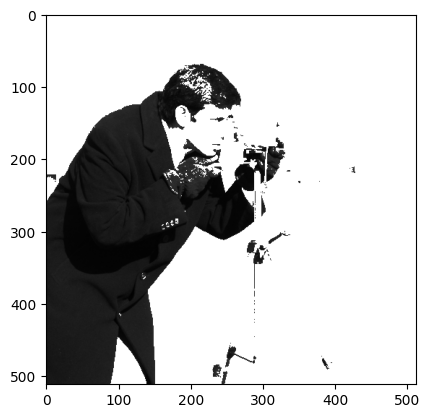

In [4]:
masked_camera = camera.copy()
mask = camera > 50
masked_camera[mask] = 255
plt.imshow(masked_camera, cmap='gray')

Now, how do we find the best one? We can try several thresholds...

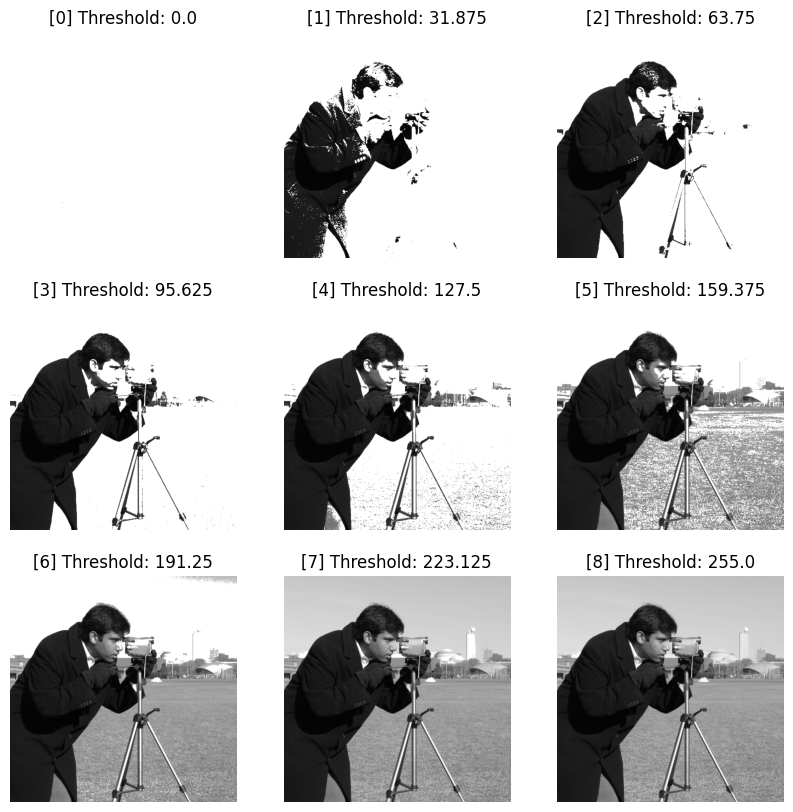

In [5]:
n_thresholds = 9
thresholds = np.linspace(
    0,
    255,
    n_thresholds
)
fig, axes = plt.subplots(
    int(np.sqrt(n_thresholds)),
    int(np.sqrt(n_thresholds)),
    figsize=(10, 10),
)
axes = axes.reshape(-1)
for idx, t in enumerate(thresholds):
    masked_camera = camera.copy()
    mask = camera > t
    masked_camera[mask] = 255
    axes[idx].imshow(masked_camera, cmap='gray')
    axes[idx].set_title(f"[{idx}] Threshold: {t}")
    axes[idx].axis('off')

plt.show()

Quiz: Which threshold do you think is the best, or the closest to it?

---

We can simply apply the [Otsu's method](https://en.wikipedia.org/wiki/Otsu's_method) to find the best one

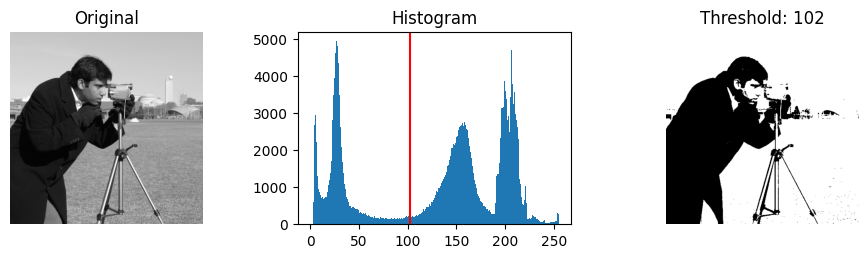

In [6]:
otsu_thresh = ski.filters.threshold_otsu(camera)
masked = camera > otsu_thresh

fig, axes = plt.subplots(ncols=3, figsize=(12, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3)

ax[0].imshow(camera, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(camera.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(otsu_thresh, color='r')

ax[2].imshow(masked, cmap=plt.cm.gray)
ax[2].set_title(f"Threshold: {otsu_thresh}")
ax[2].axis('off')

plt.show()

Ok, but are there other algorithms? YES, and you can try them all out with one simple function

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


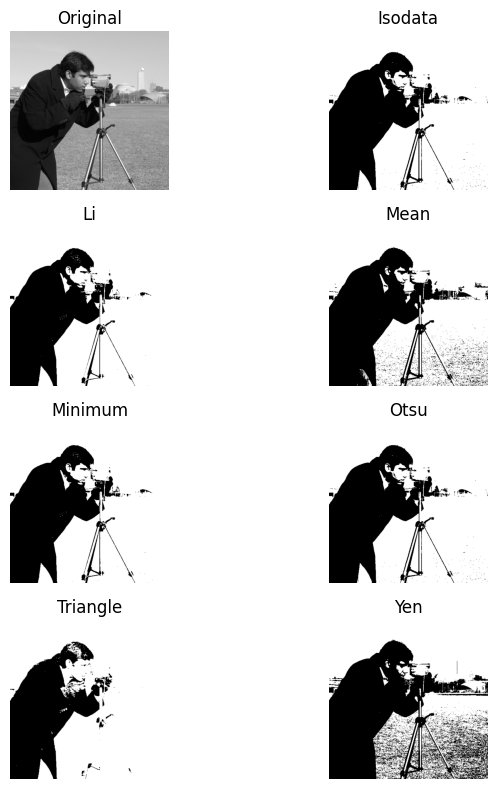

In [7]:
fig, ax = ski.filters.try_all_threshold(camera, figsize=(8, 8), verbose=True)
plt.show()

... but they do not tell the actual best threshold (argh!). We must cycle through them to find it

Mean threshold: 97.85337291883329


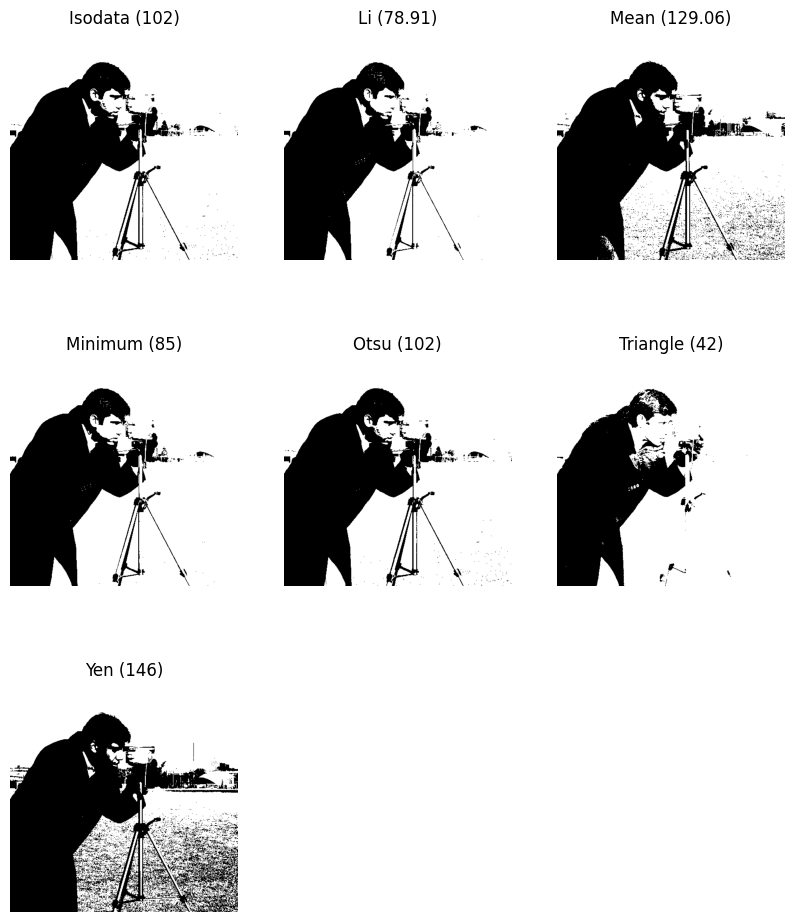

In [ ]:
methods = dict(
    zip(
        ['Isodata', 'Li', 'Mean', 'Minimum', 'Otsu', 'Triangle', 'Yen'], 
        [ski.filters.threshold_isodata, ski.filters.threshold_li, ski.filters.threshold_mean, ski.filters.threshold_minimum, ski.filters.threshold_otsu, ski.filters.threshold_triangle, ski.filters.threshold_yen]
    )
)
fig, axes = plt.subplots(
    3,
    3,
    figsize=(10, 12)
)
axes = np.ravel(axes)
thresholds = {}
for idx, (method, algorithm) in enumerate(methods.items()):
    try:
        thresh = algorithm(camera)
        thresholds[method] = thresh
        masked = camera > thresh
        axes[idx].imshow(masked, cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f"{method} ({round(thresh, 2)})")
    except Exception as e:
        print(f"Exception with algorithm {method}: {e}")

for idx in range(len(methods.keys()), len(axes)):
    axes[idx].remove()
    
print(f"Mean threshold: {np.mean(list(thresholds.values()))}")
plt.show()

# Are global filter always enough?
Let's see it with another image...

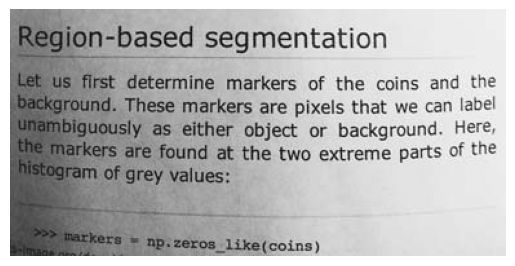

In [17]:
page = ski.data.page()
plt.imshow(page, cmap='gray')
plt.axis('off')
plt.show()

Let's apply our dear filters as we did before...

Mean threshold: 164.22277205494225


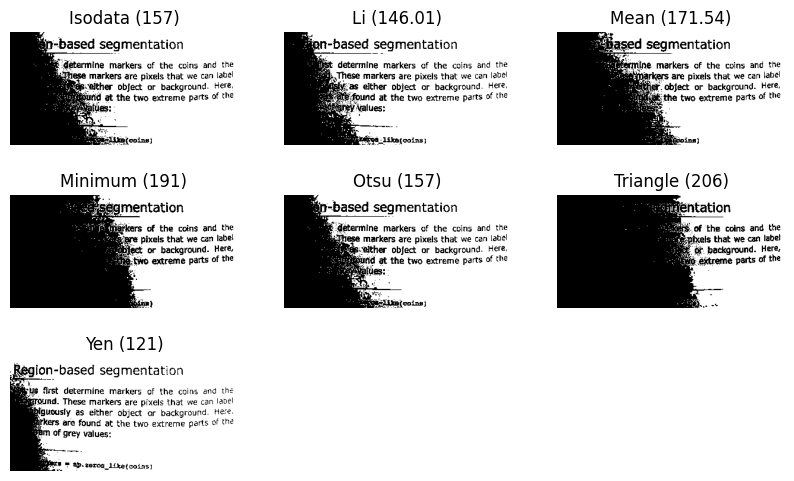

In [20]:
fig, axes = plt.subplots(
    3,
    3,
    figsize=(10, 6)
)
axes = np.ravel(axes)
thresholds = {}
for idx, (method, algorithm) in enumerate(methods.items()):
    try:
        thresh = algorithm(page)
        thresholds[method] = thresh
        masked = page > thresh
        axes[idx].imshow(masked, cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f"{method} ({round(thresh, 2)})")
    except Exception as e:
        print(f"Exception with algorithm {method}: {e}")

for idx in range(len(methods.keys()), len(axes)):
    axes[idx].remove()
    
print(f"Mean threshold: {np.mean(list(thresholds.values()))}")
plt.show()

Mhm, it doesn't really work that well. A single, global threshold does not remove all the different shades of gray. We need something more specific for the shadow on the page...

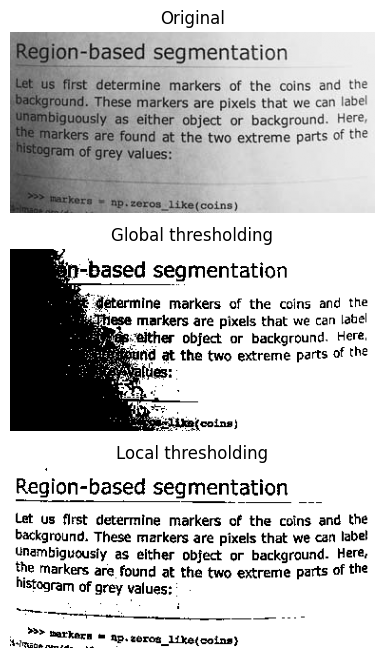

In [28]:
global_thresh = ski.filters.threshold_otsu(page)
binary_global = page > global_thresh

block_size = 35
local_thresh = ski.filters.threshold_local(page, block_size, offset=10)
binary_local = page > local_thresh

fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
ax = axes.ravel()
plt.gray()

ax[0].imshow(page)
ax[0].set_title('Original')

ax[1].imshow(binary_global)
ax[1].set_title('Global thresholding')

ax[2].imshow(binary_local)
ax[2].set_title('Local thresholding')

for a in ax:
    a.set_axis_off()

plt.show()
